In [1]:
%matplotlib inline
import importlib
import patch
import lda_utils
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import lda_utils
import os
import plot_utils

importlib.reload(patch)
importlib.reload(lda_utils)

TOPICS = 10
COLOR_WORDS = 255
SIFT_WORDS = 300
HISTOGRAM_BINS = 500
K = 1


if not os.path.exists(f"mnist/"):
    os.mkdir(f"mnist/")
if not os.path.exists("mnist/hist"):
    os.mkdir("mnist/hist")
if not os.path.exists("mnist/models"):
    os.mkdir("mnist/models")
if not os.path.exists("mnist/quantized"):
    os.mkdir("mnist/quantized")
if not os.path.exists("mnist/sift"):
    os.mkdir("mnist/sift")
if not os.path.exists("figures/mnist"):
    os.mkdir("figures/mnist")
if not os.path.exists(f"figures/mnist/{K}"):
    os.mkdir(f"figures/mnist/{K}")

with open(f"figures/mnist/{K}/summary.pkl", 'wb+') as f:
    pkl.dump({"TOPICS": TOPICS,
              "COLOR_WORDS": COLOR_WORDS,
              "SIFT_WORDS": SIFT_WORDS,
              "HISTOGRAM_BINS": HISTOGRAM_BINS}, f)

WINDOW_SIZE = 4
HISTOGRAM_VOCABULARY_FILE = os.path.join("mnist/hist/", f"mnist_histogram_vocab_{HISTOGRAM_BINS}.pkl")
NO_SIFT_MODEL_FILE = os.path.join("mnist/models/", f"mnist_no_sift_model_{COLOR_WORDS}_{HISTOGRAM_BINS}_{TOPICS}.pkl")
QUANTIZED_FILE = os.path.join("mnist/quantized/", f"mnist_image_quantized_{COLOR_WORDS}_{HISTOGRAM_BINS}.pkl")
SIFT_FILE = os.path.join("mnist/sift/", f"mnist_sift_quantized_{SIFT_WORDS}.pkl")
SIFT_QUANTIZATION = os.path.join("mnist/quantized/", f"mnist_image_sift_quantized_{SIFT_WORDS}.pkl")
SIFT_MODEL_FILE = os.path.join("mnist/models/",
                               f"mnist_sift_model_{COLOR_WORDS}_{HISTOGRAM_BINS}_{SIFT_WORDS}_{TOPICS}.pkl")
SIFT_ONLY_MODEL_FILE = os.path.join("mnist/models/",
                                    f"mnist_sift_only_model_{SIFT_WORDS}_{TOPICS}.pkl")
RUN_PATH = os.path.join(f"figures/mnist/{K}")

3.3217838325962674


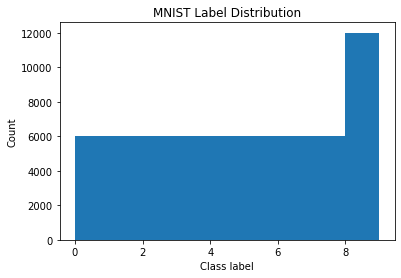

In [2]:
mnist_x, mnist_y = lda_utils.load_mnist()
mnist_x = np.stack([image.reshape(28, 28, 1) for image in mnist_x])
print(patch.compute_entropy(mnist_y, 10))
possible_topics = np.arange(np.max(mnist_y) + 1)
plt.hist(mnist_y, bins=possible_topics)
plt.title("MNIST Label Distribution")
plt.xlabel("Class label")
plt.ylabel("Count")
plt.savefig(f"figures/mnist/{K}/baseline.png")
plt.show()

In [269]:
bins = patch.get_bins(255)
if not os.path.exists(HISTOGRAM_VOCABULARY_FILE):
    histograms = []
    for i in range(len(mnist_x) // 15):
        for p in patch.get_random_patch(mnist_x[i].reshape(28, 28, 1), WINDOW_SIZE, count=10):
            histograms.append(np.histogram(p.reshape(1, -1), bins=bins)[0])
    histogram_cluster = patch.cluster(histograms, HISTOGRAM_BINS)
    with open(HISTOGRAM_VOCABULARY_FILE, 'wb+') as f:
        pkl.dump(histogram_cluster, f)
else:
    with open(HISTOGRAM_VOCABULARY_FILE, 'rb') as f:
        histogram_cluster = pkl.load(f)

In [270]:
importlib.reload(patch)
if not os.path.exists(QUANTIZED_FILE):
    quantized_histograms = patch.get_histograms_no_color(mnist_x, histogram_cluster, 255,
                                                         HISTOGRAM_BINS, WINDOW_SIZE)
    with open(QUANTIZED_FILE, 'wb+') as f:
        pkl.dump(quantized_histograms, f)
else:
    with open(QUANTIZED_FILE, 'rb') as f:
        quantized_histograms = pkl.load(f)

In [337]:
from sklearn.decomposition import LatentDirichletAllocation

model = LatentDirichletAllocation(TOPICS)

In [338]:
if not os.path.exists(NO_SIFT_MODEL_FILE):
    model.fit(quantized_histograms)
    with open(NO_SIFT_MODEL_FILE, 'wb+') as f:
        pkl.dump(model, f)
else:
    with open(NO_SIFT_MODEL_FILE, 'rb') as f:
        model = pkl.load(f)


In [339]:
topics = np.argmax(model.transform(quantized_histograms), axis=1)
possible = [np.where(topics == i)[0] for i in range(TOPICS)]

In [340]:
for captured_topic in range(TOPICS):
    plot_utils.plot_topic(mnist_x[possible[captured_topic]], RUN_PATH, "histogram", captured_topic)
    plt.close()

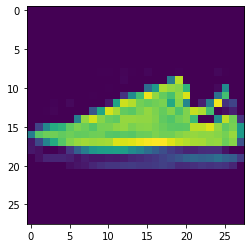

In [239]:
plt.imshow(mnist_x[possible[1][1]])

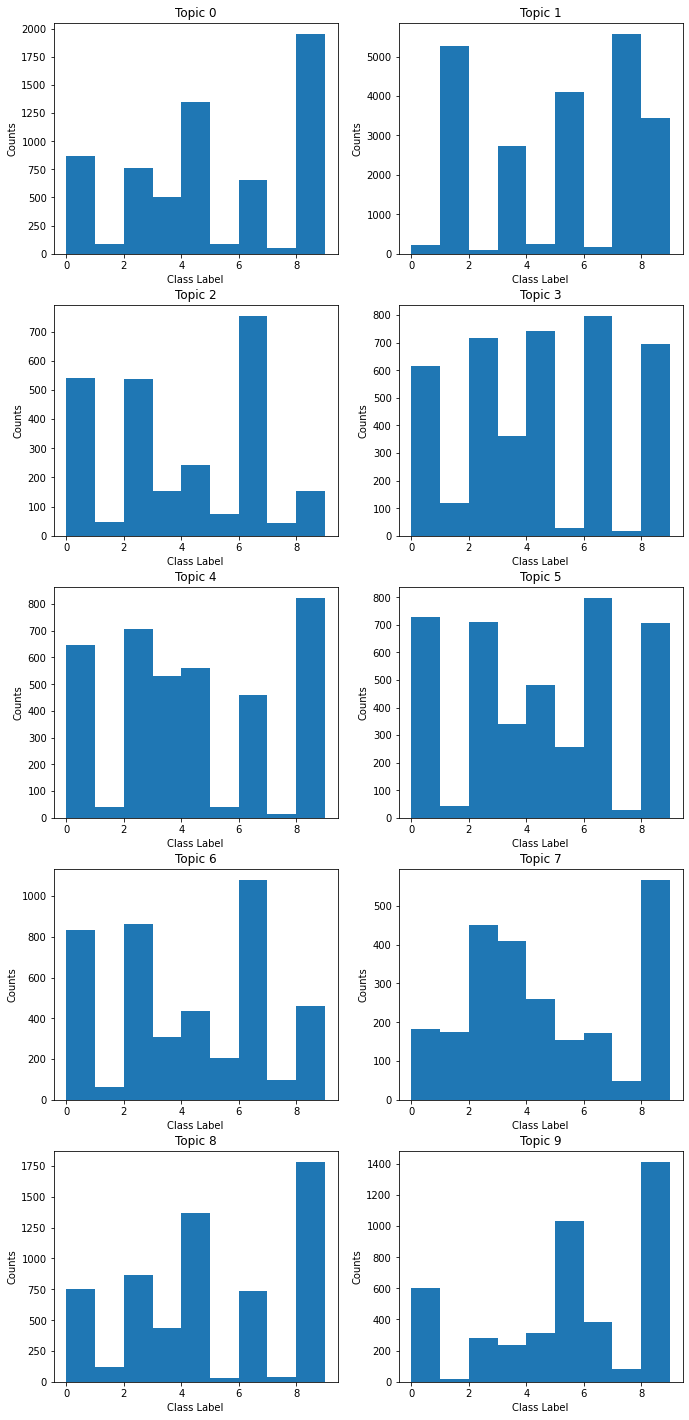

In [275]:
importlib.reload(patch)
fig, axs = plt.subplots(TOPICS//2, 2, figsize=(10, 20))
fig.tight_layout(pad=3.0)
entropy = []
plt.title("Histogram Only")
for i, (ax, p) in enumerate(zip(axs.flatten(), possible)):
    ax.set_title(f"Topic {i}")
    ax.set_xlabel("Class Label")
    ax.set_ylabel("Counts")
    ax.hist(mnist_y[p], bins=possible_topics)
    entropy.append(patch.compute_entropy(mnist_y[p], 10))
plt.savefig(f"figures/mnist/{K}/no_sift_distribution.png")
plt.show()

with open(f"figures/mnist/{K}/histogram_entropy.pkl", 'wb') as f:
    pkl.dump(entropy, f)

In [276]:
_, features = patch.get_sift(mnist_x[0])

In [277]:
import random

if not os.path.exists(SIFT_FILE):
    features = []
    sampled_images = sorted(random.sample([i for i in range(len(mnist_x))], k=len(mnist_x) // 10))
    for i in sampled_images:
        feature = patch.get_sift(mnist_x[i])[1]
        if feature is None:
            continue
        indexes = random.sample(list(range(len(feature))), k=min(10, len(feature)))
        features.extend([f for f in feature[indexes]])
    sift_cluster = patch.cluster(features, SIFT_WORDS)
    with open(SIFT_FILE, 'wb+') as f:
        pkl.dump(sift_cluster, f)
else:
    with open(SIFT_FILE, 'rb') as f:
        sift_cluster = pkl.load(f)

In [278]:
sift_bins = patch.get_bins(SIFT_WORDS)
if not os.path.exists(SIFT_QUANTIZATION):
    quantized_sift = []
    for _, image in enumerate(mnist_x):
        feature = patch.get_sift(image)[1]
        if feature is None:
            quantized_sift.append(np.zeros(sift_bins.shape[0] - 1))
            continue
        h = np.histogram(sift_cluster.predict(feature.astype(np.double)), bins=sift_bins)[0]
        quantized_sift.append(h)
    quantized_sift = np.stack(quantized_sift)
    with open(SIFT_QUANTIZATION, 'wb+') as f:
        pkl.dump(quantized_sift, f)
else:
    with open(SIFT_QUANTIZATION, 'rb') as f:
        quantized_sift = pkl.load(f)

In [331]:
sift_only_model = LatentDirichletAllocation(TOPICS)

In [334]:
if not os.path.exists(SIFT_ONLY_MODEL_FILE):
    sift_only_model.fit(quantized_sift)
    with open(SIFT_ONLY_MODEL_FILE, "wb+") as f:
        pkl.dump(sift_only_model, f)
else:
    with open(SIFT_ONLY_MODEL_FILE, 'rb') as f:
        sift_only_model = pkl.load(f)

In [335]:
sift_only_topics = np.argmax(sift_only_model.transform(quantized_sift), axis=1)
possible = [np.where(sift_only_topics == i)[0] for i in range(TOPICS)]

In [336]:
for captured_topic in range(TOPICS):
    plot_utils.plot_topic(mnist_x[possible[captured_topic]], RUN_PATH, "sift_only", captured_topic)
    plt.close()

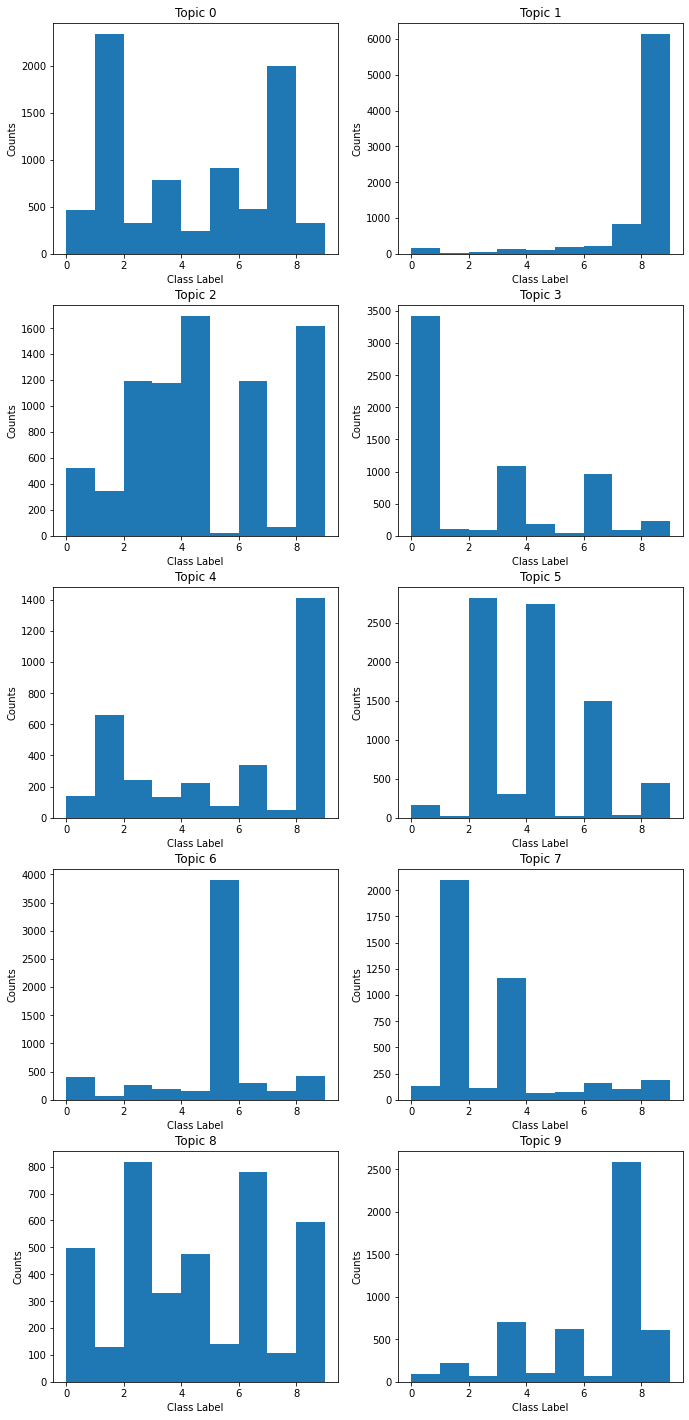

In [282]:
possible_topics = np.arange(np.max(mnist_y) + 1)
fig, axs = plt.subplots(TOPICS//2, 2, figsize=(10, 20))
fig.tight_layout(pad=3.0)
sift_only_entropy = []
for i, (ax, p) in enumerate(zip(axs.flatten(), possible)):
    ax.set_title(f"Topic {i}")
    ax.set_xlabel("Class Label")
    ax.set_ylabel("Counts")
    ax.hist(mnist_y[p], bins=possible_topics)
    sift_only_entropy.append(patch.compute_entropy(mnist_y[p], TOPICS))
plt.savefig(f"figures/mnist/{K}/sift_only_distribution.png")
plt.show()

with open(f"figures/mnist/{K}/sift_entropy.pkl", 'wb') as f:
    pkl.dump(sift_only_entropy, f)

In [314]:
sift_combined_quantization = np.concatenate([np.stack(quantized_histograms), quantized_sift], axis=1)
combined_model = LatentDirichletAllocation(TOPICS)

In [315]:
if not os.path.exists(SIFT_MODEL_FILE):
    combined_model.fit(sift_combined_quantization)
    with open(SIFT_MODEL_FILE, 'wb+') as f:
        pkl.dump(combined_model, f)
else:
    with open(SIFT_MODEL_FILE, 'rb') as f:
        combined_model = pkl.load(f)

In [316]:
improved_topics = np.argmax(combined_model.transform(sift_combined_quantization), axis=1)
possible = [np.where(improved_topics == i)[0] for i in range(TOPICS)]

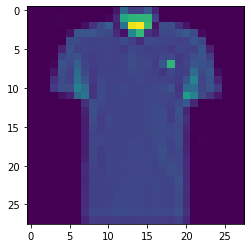

In [317]:
plt.imshow(mnist_x[possible[0][6]])

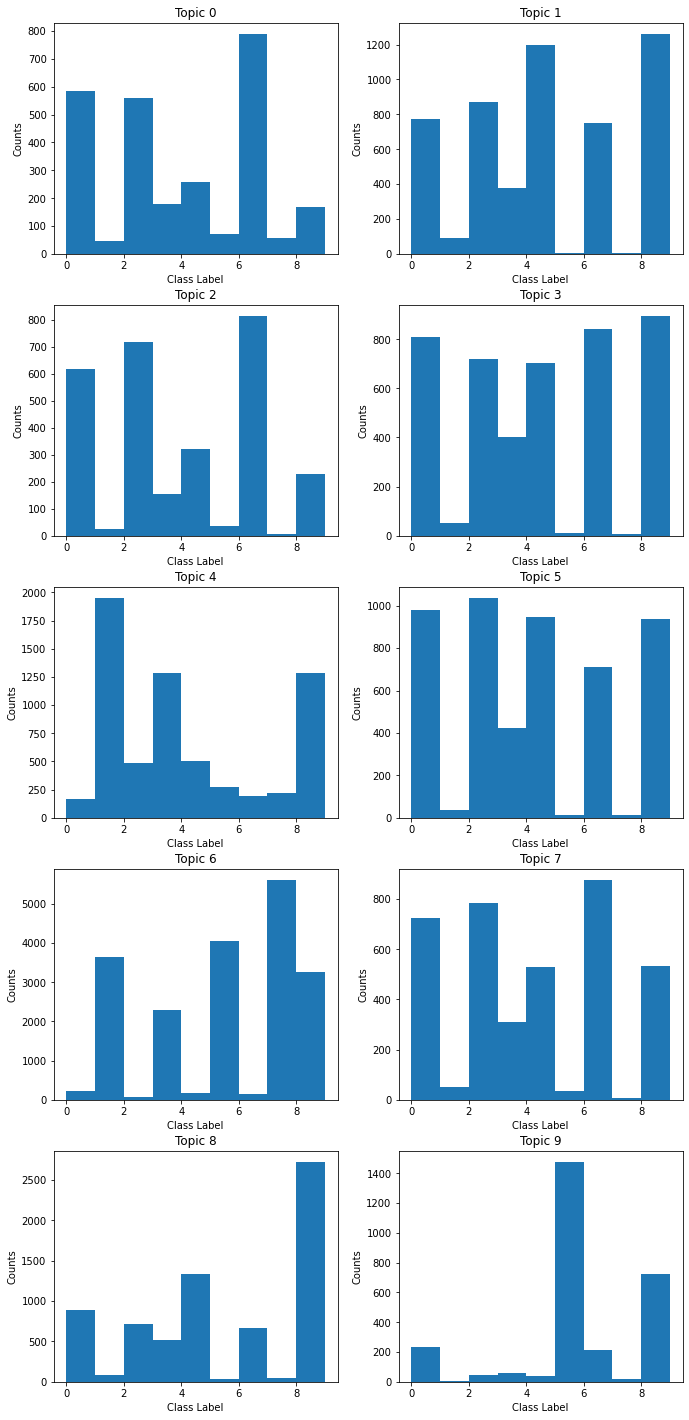

In [318]:
possible_topics = np.arange(np.max(mnist_y) + 1)
fig, axs = plt.subplots(TOPICS//2, 2, figsize=(10, 20))
fig.tight_layout(pad=3.0)
combined_entropy = []
for i, (ax, p) in enumerate(zip(axs.flatten(), possible)):
    ax.set_title(f"Topic {i}")
    ax.set_xlabel("Class Label")
    ax.set_ylabel("Counts")
    ax.hist(mnist_y[p], bins=possible_topics)
    combined_entropy.append(patch.compute_entropy(mnist_y[p], TOPICS))
plt.savefig(f"figures/mnist/{K}/combined_distribution.png")
plt.show()
with open(f"figures/mnist/{K}/combined_entropy.pkl", 'wb') as f:
    pkl.dump(combined_entropy, f)

In [319]:
np.mean(combined_entropy)

2.684796407370181

In [320]:
np.mean(sift_only_entropy)

2.3475733734196993

In [321]:
np.mean(entropy)

2.878043584847755

In [330]:
import plot_utils
importlib.reload(plot_utils)
for captured_topic in range(TOPICS):
    plot_utils.plot_topic(mnist_x[possible[captured_topic]], RUN_PATH, "combined", captured_topic)
    plt.close()